# Load data and graph

### Imports


In [ ]:
import csv
import networkx as nx
import numpy as np
from random import randint
import random
import csv
import networkx as nx
import numpy as np
from random import randint
from sklearn.linear_model import LogisticRegression
from xgboost import plot_importance

PATH = '/content/drive/MyDrive/mva/Altegrad/'
EDGE_LIST_PATH = PATH +'citation-prediction-altegrad/edgelist.txt'
AUTHORS_LIST_PATH = PATH +'citation-prediction-altegrad/authors.txt'

In [ ]:
from sklearn.metrics import plot_confusion_matrix, log_loss, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import smart_open
import gensim

def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

def other_metrics(graph, edges):
    similarity_dice = graph.similarity_dice(pairs = edges)
    similarity_jaccard = graph.similarity_jaccard(pairs = edges)
    return similarity_dice, similarity_jaccard

def evaluate_estimator(clf, X_test, y_test):
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()
    y_pred = clf.predict_proba(X_test)[:, 1]
    print("accuracy",accuracy_score(y_test, (y_pred>0.5)))
    print("log_loss", log_loss(y_test, y_pred, eps=1e-7))
    print("auc", roc_auc_score(y_test, y_pred))
    plt.hist(y_pred)
    plt.show()
    

### DGL import

In [ ]:
#! pip install dgl

In [ ]:
!pip install dgl-cu110 -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 143.5 MB 7.8 kB/s 


In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
from dgl.nn import SAGEConv
import dgl.function as fn
import torch

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Load graph

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create a graph
G = nx.read_edgelist(EDGE_LIST_PATH, delimiter=',', create_using=nx.Graph(), nodetype=int)
nodes = list(G.nodes())
n = G.number_of_nodes()
m = G.number_of_edges()
print('Number of nodes:', n)
print('Number of edges:', m)

Number of nodes: 138499
Number of edges: 1091955


### Negative edges




Create **negative edges** with random sampling of pair of nodes

In [ ]:
neg_G = nx.read_edgelist(PATH+'negative_edgelist.txt', delimiter=',', nodetype=int)


print('Number of nodes:', neg_G.number_of_nodes())
print('Number of edges:', neg_G.number_of_edges())

Number of nodes: 138499
Number of edges: 1456999


In [ ]:
def generate_negative_edges(G, m):
    f = open(PATH +"negative_edgelist.txt", "w")
    my_set = list(neg_G.edges())
    n = G.number_of_nodes()
    edges = list(G.edges())
    string = ''
    for edge in my_set:
        n1, n2 = edge
        string +=str(n1) +',' +str(n2)+'\n'

    while len(my_set)<m:
        n1 = nodes[randint(0, n-1)]
        n2 = nodes[randint(0, n-1)]
        while ((n1,n2) in my_set or (n2,n1) in my_set) or ((n1,n2) in edges or (n2,n1) in edges):
            n2 = nodes[randint(0, n-1)]
        my_set.append((n1,n2))
        string += str(n1) +',' +str(n2)+'\n'

        if len(my_set)%10000==0:
            f.write(string)
            string = ''

    f.close() 
    del my_set

#generate_negative_edges(G, m=3*G.number_of_edges())

# Node Embeddings

Create node embeddings for every research paper on the dataset. 
Include research on authors embeddings.

Split dataset.

## Create nodes features

#### Authors Graph

We use the author graph to create node embeddings. We tried hot-autoencoder and random walks with different libraries.

In [ ]:
! pip install unidecode

     |████████████████████████████████| 235 kB 7.7 MB/s 


In [ ]:
import re
from sklearn.preprocessing import OneHotEncoder
import csv
import networkx as nx
import numpy as np
from random import randint
import unidecode


regex = re.compile('[^a-zA-Z ,]')

def process_author(s):
    l = s.split()
    l = [m[:3].upper() for m in l]
    return ' '.join(l)

def process_authors_split(s):
    s = s.replace('Janne Heikkil #x E', 'Janne Heikkila')
    s = s.replace('Samuel Rota Bul #x F', "Samuel Rota Bulo")
    s = s.replace('Maria Salam #x F,Llorente', 'Maria Salamo Llorente')
    s = s.replace('Patrick H #x E,as,dric Herzet', 'Patrick Heas, Cedric Herzet')
    s = s.replace('Etienne M #x E,min', 'Etienne Memin')
    s = regex.sub('', s)
    
    authors_split = s.split(',')
    authors_split = [process_author(a) for a in authors_split]
    
    return authors_split

authors_per_node = [] # for hot encoder
author_dic = {} # attribute a number to all authors
count_authors = 0

with open(AUTHORS_LIST_PATH, 'r', errors = 'strict') as f:
    for line in f:
        #do stuff
        node, authors = line.split('|--|')
        
        #process errors
        authors = unidecode.unidecode(authors)

        #', -'
        authors_split = process_authors_split(authors)
        authors_node = []

        for author in authors_split:
            if author not in author_dic.keys():
                author_dic[author] = count_authors
                count_authors += 1
            authors_node.append(author_dic[author])
        authors_per_node.append(authors_node)

max_author_per_node = max([len(authors_per_node[i]) for i in range(len(authors_per_node))])

##### Random walk with stellarGraph


In [ ]:
! pip install stellargraph

In [ ]:
import gc
from gensim.models import Word2Vec

authors_G = nx.Graph()

edges = G.edges()
for edge in edges:
    n1, n2 = edge
    for author1 in authors_per_node[n1]:
        for author2 in authors_per_node[n2]:
            if authors_G.has_edge(author1, author2):
                # we added this one before, just increase the weight by one
                authors_G[author1][author2]['weight'] += 1
            else:
                # new edge. add with weight=1
                authors_G.add_edge(author1, author2, weight=1)
print("graph authors done")
print("authors edges",authors_G.number_of_edges())
print("authors nodes",authors_G.number_of_nodes())

n_authors = authors_G.number_of_nodes()

del authors_per_node, G, author_dic
gc.collect()


In [ ]:
author_graph = StellarGraph.from_networkx(authors_G)

rw = BiasedRandomWalk(author_graph)

walks = rw.run(
    nodes=list(author_graph.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

node_ids = [int(id) for id in model.wv.index2word]  # list of node IDs
mixed_authors_embeddings = (model.wv.vectors)  
authors_embeddings = np.array([emb for _,emb in sorted(zip(node_ids,mixed_authors_embeddings))])

def get_node_embedding(node, vecs=authors_embeddings):
    authors = authors_per_node[node]

    emb_node = np.mean([vecs[i] for i in authors], axis = 0)
    return emb_node

Number of random walks: 1062010


In [ ]:
def get_node_embedding_from_authors(node, vecs=authors_embeddings):
    authors = authors_per_node[node]
    emb_node = np.mean([vecs[i] for i in authors], axis = 0)
    return emb_node

In [ ]:
with open("embeddingAUTHORS.npy", 'wb') as f:
    np.save(f, authors_embeddings)

##### Random walk with DGL

In [ ]:
edges = G.edges()
u, v = list(), list()
for edge in edges:
    n1, n2 = edge
    for author1 in authors_per_node[n1]:
        for author2 in authors_per_node[n2]:
            u.append(author1)
            v.append(author2)

authors_graph = dgl.graph((torch.tensor(u), torch.tensor(v)))

def authors_rw(node, size=20, l=5):
    encoder = []
    for i in range(size//l):
        start = np.random.choice(authors_per_node[node])
        next = dgl.sampling.node2vec_random_walk(authors_graph, start, 1, 1, l)
        for i in range(1,len(next[0])):
            encoder.append(int(next[0][i].detach()))
    return encoder




### Add node features

Add doc2vec and use results,
Add author embedding,
and some basic node features.

In [ ]:
lenght_rw = 21
lenght = 3

node_features = np.zeros((n, 514+512+128))

with open(PATH+'doc2vec_emb.npy', 'rb') as f:
      vecs = np.load(f)

with open(PATH+'USE_embedding.npy', 'rb') as f:
      use = np.load(f)

for i, node in enumerate(G.nodes):
    node_features[i, 0] = G.degree(node) # degree of the node
    node_features[i, 1] = len(authors_per_node[i]) # number of authors
    node_features[i, 2:514] = vecs[i] # Word2vec abstract embedding
    node_features[i, 514:514+512] = use[i] # Use abstract embedding
    node_features[i, 514+512:] = get_node_embedding_from_authors(node) # node2vec authorgraph with stellagraph, with dgl use : authors_rw(node, size=lenght_rw, l=lenght)

del authors_per_node, author_dic

## Split and prepare dataset

In [ ]:
from dgl.ndarray import cpu
random.seed(10)
test_size = int(G.number_of_edges() * 0.1)
train_size = G.number_of_edges() - test_size

# Split edge set for training and testing
g = dgl.from_networkx(G).to(device)
u, v = g.edges()
eids = np.random.permutation(np.arange(g.number_of_edges()))
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Same with negative edges
test_size = test_size # int(neg_G.number_of_edges() * 0.1)
neg_g = dgl.from_networkx(neg_G)
neg_u, neg_v = neg_g.edges()
neg_eids = np.random.permutation(np.arange(len(neg_u)))
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

del neg_u, neg_v, neg_eids
del u, v, eids

In [ ]:
with open(PATH+"train_test_split.npy", 'wb') as f:
    np.save(f, train_pos_u.cpu().detach().numpy())
    np.save(f, train_pos_v.cpu().detach().numpy())
    np.save(f, train_neg_u.cpu().detach().numpy())
    np.save(f, train_neg_v.cpu().detach().numpy())
    
    np.save(f, test_pos_u.cpu().detach().numpy())
    np.save(f, test_pos_v.cpu().detach().numpy())
    np.save(f, test_neg_u.cpu().detach().numpy())
    np.save(f, test_neg_v.cpu().detach().numpy())

In [ ]:

# --------- 1. Prepare dataset ------------- #

train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()).to(device)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes()).to(device)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)

del train_neg_v, train_neg_u, train_pos_v, train_pos_u


# Add node features to graphs
train_pos_g.ndata['feat'] = torch.tensor(node_features).type(torch.float32).to(device)
g.ndata['feat'] = torch.tensor(node_features).type(torch.float32).to(device)

# GraphSAGE

Train a CraphSAGE embedding, with a MLP.

In [ ]:

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


def compute_loss(pos_score, neg_score, weights=None,device = device):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy(scores, labels,weight=weights)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).cpu().detach().numpy()
    return roc_auc_score(labels, scores)

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats * 5)
        self.W2 = nn.Linear(h_feats * 5, h_feats)
        self.W3 = nn.Linear(h_feats, 1)
        self.sig = nn.Sigmoid()
        self.drop1 = nn.Dropout(p=0.5)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        output =  self.sig(self.W3(F.relu(self.W2(self.drop1(F.relu(self.W1(h)))))))
        return {'score': output.squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

    def output(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges_test)
            return g.edata['score']

    def apply_edges_test(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        output =  self.sig(self.W3(F.relu(self.W2(F.relu(self.W1(h))))))
        return {'score': output.squeeze(1)}

In epoch 0, training loss: 0.7733775973320007, validation loss: 1.3882930278778076
In epoch 5, training loss: 0.6782967448234558, validation loss: 0.6902710199356079
In epoch 10, training loss: 0.6786903738975525, validation loss: 0.6952411532402039
In epoch 15, training loss: 0.6650831699371338, validation loss: 0.6747903227806091
In epoch 20, training loss: 0.6443881988525391, validation loss: 0.6649748086929321
In epoch 25, training loss: 0.610381543636322, validation loss: 0.6235160231590271
In epoch 30, training loss: 0.5574725270271301, validation loss: 0.5651547908782959
In epoch 35, training loss: 0.5056649446487427, validation loss: 0.5192344188690186
In epoch 40, training loss: 0.4624592363834381, validation loss: 0.481560081243515
In epoch 45, training loss: 0.43866124749183655, validation loss: 0.44334670901298523
In epoch 50, training loss: 0.40619194507598877, validation loss: 0.44532597064971924
In epoch 55, training loss: 0.3803980052471161, validation loss: 0.397564470

Text(0.5, 1.0, 'Scores through training')

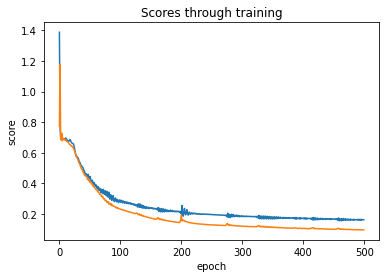

In [ ]:
# ----------- Parameters -------------- #
nepochs = 500
milestones = np.arange(0, nepochs, 450)
lr = 0.01
gamma = 0.5
hidden_dim = 32


# ----------- 3. set up loss and optimizer -------------- #
model = GraphSAGE(train_pos_g.ndata['feat'].shape[1], hidden_dim).to(device)
pred = MLPPredictor(hidden_dim).to(device)
# in this case, loss in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=lr)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# ----------- 4. training -------------------------------- #

validation_scores = []
training_scores = []
min_loss = np.infty
for e in range(nepochs):
    # forward
    h = model(train_pos_g, train_pos_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    # weights = torch.cat([2*torch.ones(pos_score.shape[0]), torch.ones(neg_score.shape[0])]).to(device)
    loss = compute_loss(pos_score, neg_score)
    

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
  
    pos_score = pred.output(test_pos_g, h)
    neg_score = pred.output(test_neg_g, h)
    val_loss = compute_loss(pos_score, neg_score)
    training_scores.append(loss.cpu().detach().numpy())
    validation_scores.append(val_loss.cpu().detach().numpy())



    if e % 5 == 0:
        print('In epoch {}, training loss: {}, validation loss: {}'.format(e, loss, val_loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

plt.plot(np.arange(nepochs), validation_scores, label='val')
plt.plot(np.arange(nepochs), training_scores, label='train')
plt.xlabel("epoch")
plt.ylabel("score")
plt.title('Scores through training')

# Prediction

Retrain graphsage on full dataset,
Choose classifier,
Write prediction file

### Train GraphSage on full dataset

In [ ]:
# ----------- Parameters -------------- #
nepochs = 450
milestones = np.arange(0, nepochs, 400)
lr = 0.01
gamma = 0.5
hidden_dim = 32


# ----------- 3. set up loss and optimizer -------------- #
model = GraphSAGE(train_pos_g.ndata['feat'].shape[1], hidden_dim).to(device)
pred = MLPPredictor(hidden_dim).to(device)
# in this case, loss in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=lr)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# ----------- 4. training -------------------------------- #

validation_scores = []
training_scores = []
min_loss = np.infty
for e in range(nepochs):
    # forward
    h = model(train_pos_g, train_pos_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    #weights = torch.cat([2*torch.ones(pos_score.shape[0]), torch.ones(neg_score.shape[0])]).to(device)
    loss = compute_loss(pos_score, neg_score)
    

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()

    if e % 5 == 0:
        print('In epoch {}, training loss: {}'.format(e, loss))

In epoch 0, training loss: 0.7090413570404053
In epoch 5, training loss: 0.68782639503479
In epoch 10, training loss: 0.6723989248275757
In epoch 15, training loss: 0.6246200799942017
In epoch 20, training loss: 0.5637667775154114
In epoch 25, training loss: 0.5204281210899353
In epoch 30, training loss: 0.4838293194770813
In epoch 35, training loss: 0.44801729917526245
In epoch 40, training loss: 0.4243641495704651
In epoch 45, training loss: 0.40974128246307373
In epoch 50, training loss: 0.3805137574672699
In epoch 55, training loss: 0.3594801723957062
In epoch 60, training loss: 0.3453100919723511
In epoch 65, training loss: 0.33180806040763855
In epoch 70, training loss: 0.31633180379867554
In epoch 75, training loss: 0.2923279106616974
In epoch 80, training loss: 0.26378992199897766
In epoch 85, training loss: 0.28803834319114685
In epoch 90, training loss: 0.2530663311481476
In epoch 95, training loss: 0.24017050862312317
In epoch 100, training loss: 0.23229211568832397
In epoch

In [ ]:
with open("embeddingSAGE.npy", 'wb') as f:
    np.save(f, h.cpu().detach().numpy())

### Classifier with NLP

In [ ]:
# Write predictions to a file
TEST_EDGE_LIST_PATH = PATH+"citation-prediction-altegrad/test.txt"
G_test = nx.read_edgelist(TEST_EDGE_LIST_PATH, delimiter=',', create_using=nx.Graph(), nodetype=int)
G_test.add_nodes_from(G)
dgl_test = dgl.from_networkx(G_test).to(device)

test_u, test_v = dgl_test.edges()
test_g = dgl.graph((test_u, test_v), num_nodes=g.number_of_nodes())

h = model(g, g.ndata['feat'])
y_pred = pred.output(test_g, h)

### Classifier with XGB boost

In [ ]:

import random

boolSAGE = True

if boolSAGE:
    with open(PATH+'/train_test_split.npy', 'rb') as f:
        
        train_pos_u = np.load(f)
        train_pos_v = np.load(f)
        train_neg_u = np.load(f)
        train_neg_v = np.load(f)

        test_pos_u = np.load(f)
        test_pos_v = np.load(f)
        test_neg_u = np.load(f)
        test_neg_v = np.load(f)
        
    test_edge_list_split = [(test_pos_u[i], test_pos_v[i]) for i in range(len(test_pos_u))]
    test_neg_edge_list = [(test_neg_u[i], test_neg_v[i]) for i in range(len(test_neg_u))]
    del train_pos_u, train_pos_v, train_neg_u, train_neg_v, test_pos_u, test_pos_v, test_neg_u, test_neg_v

else:
    test_edge_list_split = random.sample(G.edges(), int(0.5 * G.number_of_edges()))
    test_edge_list = list(test_edge_list_split)
    test_neg_edge_list = random.sample(neg_G.edges(), int(0.5 * neg_G.number_of_edges()))

# Remove some edges
train_G = G.copy()
train_G.remove_edges_from(test_edge_list_split)
train_neg_G = neg_G.copy()
train_neg_G.remove_edges_from(test_neg_edge_list)


In [ ]:
import xgboost as xgb

def give_features_from_embedding(emb, edges):
    '''
    edges can be an iterator
    '''
    dist = emb[[i for i in map(lambda x: x[0], edges)]] - emb[[i for i in map(lambda x: x[1], edges)]]
    l2_dist_neg = np.linalg.norm(dist, ord = 2, axis = 1)
    l1_dist_neg = np.linalg.norm(dist, ord = 1, axis = 1)
    del dist
    
    hadamard_neg = np.sum(emb[[i for i in map(lambda x: x[0],  edges)]] * emb[[i for i in map(lambda x: x[1],  edges)]], axis = 1)
    
    return np.c_[l2_dist_neg, l1_dist_neg, hadamard_neg]


# Train dataset 
h = model(train_pos_g, train_pos_g.ndata['feat'])
X_pos = give_features_from_embedding(h, G.edges())
X_neg = give_features_from_embedding(h, neg_G.edges())
X_train = torch.cat([X_pos, X_neg])
y_train = torch.cat([torch.ones(X_pos.shape[0]), torch.zeros(X_neg.shape[0])])

c = list(zip(X_train, y_train))
random.shuffle(c)
X_train, y_train = zip(*c)

# Test dataset


test_edge_list = [(test_pos_u[i], test_pos_v[i]) for i in range(len(test_pos_u))]
test_neg_edge_list = [(test_neg_u[i], test_neg_v[i]) for i in range(len(test_neg_u))]

y_test = np.zeros(len(test_edge_list_split) + len(test_neg_edge_list))
y_test[:len(test_edge_list_split)] = 1

test_nodes = test_edge_list + test_neg_edge_list
del test_edge_list_split, test_neg_edge_list

X_test = give_features_from_embedding(h.cpu().detach().numpy(), test_nodes)


clf = xgb.XGBClassifier(n_estimators = 800, max_depth = 4, subsample = 0.7, colsample_bytree = 0.75,  tree_method = 'gpu_hist',gpu_predictor = 'gpu_predictor')
clf.fit(X_train, y_train)


evaluate_estimator(clf, X_test, y_test)

###Write prediction file

In [ ]:
test_edges = list(G_test.edges())
u_test, v_test =  test_g.edges()
list_edges = list(zip(u_test.cpu().detach().numpy(), v_test.cpu().detach().numpy()))

dict_idx = {}
for j,pair in enumerate(list_edges):
    dict_idx[pair] = j
    
file = open(TEST_EDGE_LIST_PATH, "r")
submission_file = open(PATH+"submission.csv","w")
csv_out = csv.writer(submission_file)
csv_out.writerow(['id','predicted'])

count = 0
for line in file:
    line_edge = line.split(',')
    e = (int(line_edge[0]), int(line_edge[1]))
    try:
        #idx = list_edges.index(e)
        row = [count, float(y_pred[dict_idx[e]].detach())]
        csv_out.writerow(row)
    except:
        break
    count += 1
    
file.close()
submission_file.close()


In [ ]:
pos = 0
neg = 0
for i in y_pred:
    if float(i.detach())>0.5:
      pos+=1
    else :
      neg+=1

In [ ]:
pos, neg

(96861, 116523)